##### Setup: Import Libraries and Load Data #####

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

np.random.seed(42)

# Load in data
df_purchase = pd.read_csv('purchase_data.csv')

# Initial exploration
df_purchase.info()

# Binary Target of 'purchased' column
df_purchase['purchased'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   time_on_site           10000 non-null  float64
 1   pages_visited          10000 non-null  int64  
 2   age                    10000 non-null  float64
 3   previous_purchases     10000 non-null  int64  
 4   cart_value             10000 non-null  float64
 5   session_count          10000 non-null  int64  
 6   days_since_last_visit  10000 non-null  float64
 7   avg_time_per_page      10000 non-null  float64
 8   purchase_rate          10000 non-null  float64
 9   purchased              10000 non-null  int64  
dtypes: float64(6), int64(4)
memory usage: 781.4 KB


purchased
0    5000
1    5000
Name: count, dtype: int64

In [2]:
# Set X and y for splitting
X = df_purchase.drop(columns='purchased')
y = df_purchase['purchased']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
   X, y, test_size=0.2, random_state=42
)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**NOTE:** Decision trees don't require feature scaling because they make decisions based on splitting points based on the relative ordering of values, not their absolute magnitudes. Whether a feature like income is measured in dollars or scaled between 0 and 1, the tree will make identical splits; it's simply asking "is this value greater than that value?" at each decision point. 

While scaling isn't necessary, it won't harm the tree's performance since the fundamental splitting decisions remain unchanged. This is different from algorithms like linear regression or k-nearest neighbors, which are directly affected by the relative scales of features since they rely on distances or gradients in their calculations. 

The data has been scaled here to make it easier to using a different model type if needed.

##### Initial Assessment #####

Before moving to complex tuning, we need to establish a baseline performance to measure our improvements against. This step helps us understand if our subsequent tuning efforts are actually improving the model's performance and provides a reference point for how much improvement is possible.

The baseline model uses default parameters, which often provide good performance.

We use cross-validation to get a robust estimate of model performance, reducing the chance that our baseline metrics are skewed by a particularly easy or difficult subset of the data.
We can then compare the cross validation score to the model's training score to get an idea if we are overfitting or underfitting, which will inform our tuning process.
We also examine feature importance at this stage to understand which customer behaviors are naturally emerging as important predictors.

In [3]:
# Initialize baseline model
baseline_model = DecisionTreeClassifier(random_state=42)


# Perform cross-validation
baseline_scores = cross_val_score(
   baseline_model, X_train_scaled, y_train, cv=5, scoring='accuracy'
)


# Fit baseline model to examine feature importance
baseline_model.fit(X_train_scaled, y_train)
initial_importance = pd.DataFrame({
   'feature': X.columns,
   'importance': baseline_model.feature_importances_
}).sort_values('importance', ascending=False)


print("Baseline model performance:")
print(f"Accuracy: {baseline_scores.mean():.3f} (+/- {baseline_scores.std() * 2:.3f})")
print(f"Training Score: {baseline_model.score(X_train_scaled, y_train):.3f}")


print("\nInitial Feature Importance:")
print(initial_importance)

Baseline model performance:
Accuracy: 0.807 (+/- 0.011)
Training Score: 1.000

Initial Feature Importance:
                 feature  importance
8          purchase_rate    0.300370
4             cart_value    0.177698
7      avg_time_per_page    0.145794
6  days_since_last_visit    0.126556
1          pages_visited    0.092738
2                    age    0.063871
0           time_on_site    0.062104
5          session_count    0.021407
3     previous_purchases    0.009462


The baseline model is notably overfitting: training accuracy is 1.0 while cross-validation performance is 0.80.

##### Broad Exploration with Randomized Search #####

Randomized search allows us to efficiently explore a large parameter space without testing every possible combination. Instead of using fixed values, we define probability distributions for each parameter, which allows us to sample from continuous ranges and potentially discover optimal values we might not have considered with a grid search.

The key to effective randomized search is choosing appropriate distributions for each parameter. For tree depth and sample thresholds, we use integer distributions to explore different levels of model complexity. For feature selection, we use uniform distributions to try different proportions of features. This approach gives us broad coverage of the parameter space while being computationally efficient.

In [4]:
# Import scipy stats for distributions
from scipy.stats import randint, reciprocal

# Define parameter distributions for random search
param_dist = {
   # uniform distribution from 1 to 20 for max_depth
   'max_depth': randint(1, 20),
  
   # log-uniform distribution from 2 to 50 for min_samples_split
   'min_samples_split': reciprocal(a=2, b=50).rvs(1000).round().astype(int),
  
   # log-uniform distribution from 1 to 30 for min_samples_leaf
   'min_samples_leaf': reciprocal(a=1, b=20).rvs(1000).round().astype(int),
  
   # categorical distribution for criterion
   'criterion': ['gini', 'entropy']
}


# Note on distributions:
# randint(low, high) generates integers from low (inclusive) to high (exclusive)
# reciprocal(low, high) generates log-uniform data sampling more densely in the lower range


# Initialize randomized search
random_search = RandomizedSearchCV(
   DecisionTreeClassifier(random_state=42),
   param_distributions=param_dist,
   n_iter=100,  # Number of parameter settings sampled
   cv=5,
   scoring='accuracy',
   n_jobs=-1,
   random_state=42
)


# Perform random search
random_search.fit(X_train_scaled, y_train)


print("Best parameters from random search:")
print(random_search.best_params_)
print(f"Best cross-validation score: {random_search.best_score_:.3f}")
print(f"Best training score: {random_search.best_estimator_.score(X_train_scaled, y_train):.3f}")

Best parameters from random search:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 7}
Best cross-validation score: 0.853
Best training score: 0.861


The initial round of tuning was able to improve model performance - the training score shows the model is still overfitting but not to the same degree.

The hyperparameter randomized search results allow us to continue tuning with a more focused grid search.

##### Focused Optimization with Grid Search #####

After identifying promising regions of the parameter space with randomized search, we use grid search to fine-tune our model. Grid search systematically evaluates every combination of parameters within a focused range around the best parameters found during randomized search. This two-stage approach combines the broad exploration of randomized search with the thoroughness of grid search.

We create a focused parameter grid by taking the best parameters from our randomized search and exploring nearby values. For example, if a randomized search found a max_depth of 7 worked well, we might try depths of 6, 7, and 8. 

This focused search helps us find the optimal fine-tuned parameters while keeping computational costs reasonable. We would love to try every possible value but that quickly becomes computational expensive and feasibly impossible.

In [5]:
# Adjust grid based on best parameters from random search
focused_param_grid = {
  'criterion': ['entropy', 'gini'],
   # For max_depth, we'll explore values around 14 (12-16)
  # The reasoning is that tree depth often has a sweet spot,
  # and we want to make sure 14 is truly optimal
  'max_depth': [4, 5, 6, 7, 8],
   # Since min_samples_leaf=2 was optimal, we'll explore very small values
  # This suggests the model benefits from granular splits
  'min_samples_leaf': [5, 7, 9],
   # For min_samples_split, we'll create a window around 46
  # We'll use smaller steps since we're in a promising region
  'min_samples_split': [5, 7, 9]
}


# Perform grid search
grid_search = GridSearchCV(
   DecisionTreeClassifier(random_state=42),
   focused_param_grid,
   cv=5,
   scoring='accuracy',
   n_jobs=-1
)


grid_search.fit(X_train_scaled, y_train)


print("Best parameters from grid search:")
print(grid_search.best_params_)
print(f"Best cross-validation score: {grid_search.best_score_:.3f}")
print(f"Best training score: {grid_search.best_estimator_.score(X_train_scaled, y_train):.3f}")

Best parameters from grid search:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 5}
Best cross-validation score: 0.853
Best training score: 0.861


The focused grid search produced a slight improvement over the randomized search model. It also tweaked our best hyperparameters slightly - any improvement is helpful!

The training score indicates that the model is still overfitting by a similar degree, so there is more opportunity to tune. Based on these results, we will perform a second focused grid search.

In [6]:
# Still overfitting - 2nd Grid Search
focused_param_grid_two = {
  # Since gini performed well, we'll keep it but include entropy just in case
  'criterion': ['entropy', 'gini'],
   # Current best is 6, so let's explore same as above
  # This range helps us verify if 12 is truly optimal
  'max_depth': [4, 5, 6, 7, 8],
   # Current best is 7, suggesting the model benefits from detailed splits
  # Let's explore very small values to fine-tune this parameter
  'min_samples_leaf': [3, 5, 7, 9],
   # Current best is 5 at bottom range, so let's explore smaller increments
  # This helps us find the precise sweet spot for split size
  'min_samples_split': [2, 3, 4, 5, 6]
}


# Perform grid search
grid_search_two = GridSearchCV(
   DecisionTreeClassifier(random_state=42),
   focused_param_grid_two,
   cv=5,
   scoring='accuracy',
   n_jobs=-1
)


grid_search_two.fit(X_train_scaled, y_train)


print("Best parameters from grid search:")
print(grid_search_two.best_params_)
print(f"Best cross-validation score: {grid_search_two.best_score_:.3f}")
print(f"Best training score: {grid_search_two.best_estimator_.score(X_train_scaled, y_train):.3f}")

Best parameters from grid search:
{'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best cross-validation score: 0.853
Best training score: 0.861


The second focused grid search produced no marked improvement from the first; it produced almost the same model with a slight reduction in max_depth. Although  the model is still slightly overfitting (according to the training score) we will call this our best, final model. Further tuning could be done, but we might not see any improvement.



##### Final Validation #####

The final validation step is crucial in understanding how the tuned model will perform in the real world. We evaluate our model on the held-out test set, which contains data the model has never seen during training or tuning.

Beyond simple accuracy metrics, we calculate business-relevant metrics using a confusion matrix. This helps translate model performance into business impact by showing how many potential customers are correctly identified and how many are missed. These metrics help stakeholders understand the practical value of our tuned model.


Final Model Evaluation:
Best parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 7, 'min_samples_split': 2}
Cross-validation accuracy: 0.853
Test set accuracy: 0.843


<Figure size 800x600 with 0 Axes>

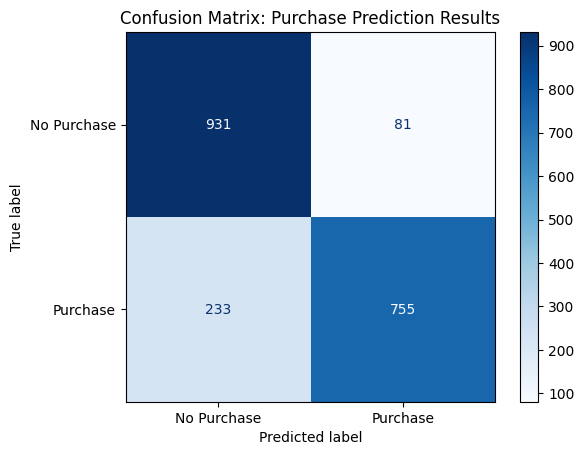


Detailed Analysis:
- Correctly identified 755 likely buyers
- Missed 233 potential customers
- Unnecessarily targeted 81 non-buyers
- Correctly avoided marketing to 931 non-interested visitors


In [7]:
# Get best model from grid search
final_model = grid_search_two.best_estimator_


# Evaluate on test set
test_score = final_model.score(X_test_scaled, y_test)


print("\nFinal Model Evaluation:")
print(f"Best parameters: {grid_search_two.best_params_}")
print(f"Cross-validation accuracy: {grid_search_two.best_score_:.3f}")
print(f"Test set accuracy: {test_score:.3f}")


# Calculate and visualize confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


# Get predictions on test set
y_pred = final_model.predict(X_test_scaled)


# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)


# Create confusion matrix display
disp = ConfusionMatrixDisplay(
   confusion_matrix=cm,
   display_labels=['No Purchase', 'Purchase']
)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix: Purchase Prediction Results')
plt.show()


# Calculate specific metrics for business interpretation
tn, fp, fn, tp = cm.ravel()


print(f"\nDetailed Analysis:")
print(f"- Correctly identified {tp} likely buyers")
print(f"- Missed {fn} potential customers")
print(f"- Unnecessarily targeted {fp} non-buyers")
print(f"- Correctly avoided marketing to {tn} non-interested visitors")

Another crucial aspect to investigate with tree based models is the feature importance. This information can help inform the business about what is driving customer purchases.



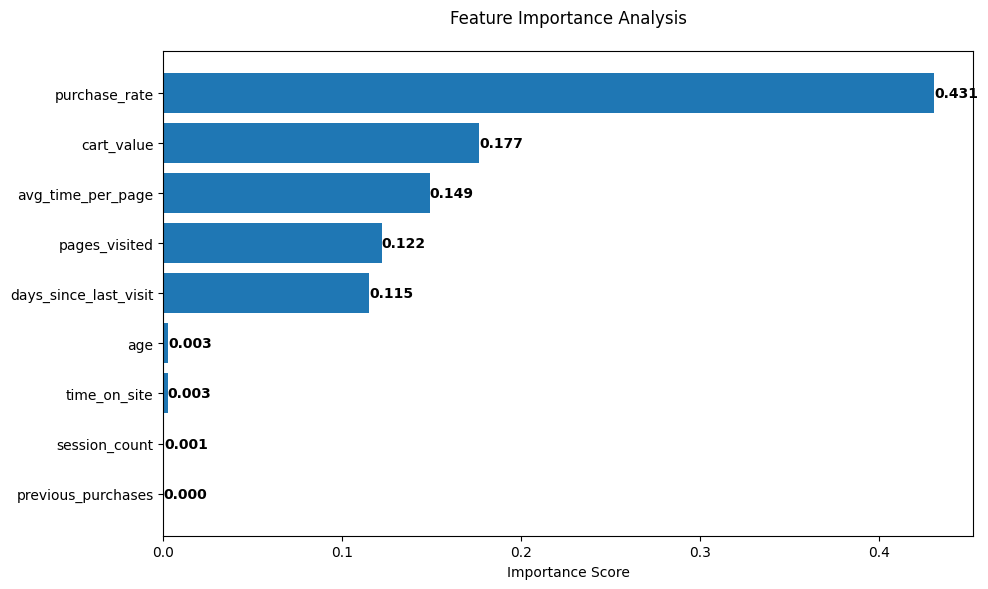

In [8]:
# Calculate feature importance
feature_importance = pd.DataFrame({
   'feature': X.columns,
   'importance': final_model.feature_importances_
}).sort_values('importance', ascending=True)


# Create the figure with a good size for readability
plt.figure(figsize=(10, 6))


bars = plt.barh(feature_importance['feature'], feature_importance['importance'])


# Customize the appearance for clarity
plt.title('Feature Importance Analysis', pad=20)
plt.xlabel('Importance Score')


# Add value labels on the bars for precise reading
# We position these just after each bar
for bar in bars:
   width = bar.get_width()
   plt.text(width, bar.get_y() + bar.get_height()/2,
            f'{width:.3f}',
            ha='left', va='center',
            fontweight='bold')


plt.tight_layout()
plt.show()

This visualization makes several things immediately apparent:

- The purchase_rate is the most influential feature, accounting for about 43% of the model's decisions.
- The top three features (purchase_rate, cart_value, and avg_time_per_page) together account for approximately 70% of the model's decision-making.
- Some features like previous_purchases and session_count have zero importance, suggesting they might be redundant or not predictive for this particular model.